In [ ]:
#hide
%load_ext autoreload
%autoreload 2

In [ ]:
# default_exp analysis

# Analysis


> The analysis functions help a modeler quickly run a full time series analysis.

An analysis consists of:
1. Initializing a DGLM, using `define_dglm`.
2. Updating the model coefficients at each time step, using `dglm.update`.
3. Forecasting at each time step between `forecast_start` and `forecast_end`, using `dglm.forecast_marginal` or `dglm.forecast_path`.
4. Returning the desired output, specified in the argument `ret`. The default is to return the model and forecast samples.

The analysis starts by defining a new DGLM with `define_dglm`. The default number of observations to use is set at `prior_length=20`. Any arguments that are used to define a model in `define_dglm` can be passed into analysis as keyword arguments. Alternatively, you may define the model beforehand, and pass the pre-initialized DGLM into analysis as the argument `model_prior`.

Once the model has been initialized, the analysis loop begins. If $\text{forecast_start} \leq t \leq \text{forecast_end}$, then the model will forecast ahead. The forecast horizon k must be specified. The default is to simulate `nsamps=500` times from the forecast distribution using `forecast_marginal`, from $1$ to `k` steps into the future. To simulate from the joint forecast distribution over the next `k` steps, set the flag `forecast_path=True`. Note that all forecasts are *out-of-sample*, i.e. they are made before the model has seen the observation. This is to ensure than the forecast accuracy is a more fair representation of future model performance.

After the forecast has been made, the model sees the observation $y_t$, and updates the state vector accordingly. 

The analysis ends after seeing the last observation in `Y`. The output is a list specified by the argument `ret`, which may contain:
- `mod`: The final model
- `forecast`: The forecast samples, stored in a 3-dimensional array with axes *nsamps* $\times$ *forecast length* $\times$ *k*
- `model_coef`: A time series of the state vector mean vector and variance matrix

Please note that `analysis` is used on a historic dataset that already exists. This means that a typical sequence of events is to run an analysis on the data you current have, and return the model and forecast samples. The forecast samples are used to evaluate the past forecast performance. Then you can use `dglm.forecast_marginal` and `dglm.forecast_path` to forecast into the future.

In [ ]:
#hide
#exporti
import numpy as np
import pandas as pd

from pybats.define_models import define_dglm, define_dcmm, define_dbcm, define_dlmm
from pybats.shared import define_holiday_regressors
from collections.abc import Iterable

## Analysis for a DGLM

In [ ]:
#export
def analysis(Y, X=None, k=1, forecast_start=0, forecast_end=0,
             nsamps=500, family = 'normal', n = None,
             model_prior = None, prior_length=20, ntrend=1,
             dates = None, holidays = [],
             seasPeriods = [], seasHarmComponents = [],
             latent_factor = None, new_latent_factors = None,
             ret=['model', 'forecast'],
             mean_only = False, forecast_path = False,
             **kwargs):
    """
    This is a helpful function to run a standard analysis. The function will:
    1. Automatically initialize a DGLM
    2. Run sequential updating
    3. Forecast at each specified time step
    """

    # Add the holiday indicator variables to the regression matrix
    nhol = len(holidays)
    X = define_holiday_regressors(X, dates, holidays)

    # Check if it's a latent factor DGLM
    if latent_factor is not None:
        is_lf = True
        nlf = latent_factor.p
    else:
        is_lf = False
        nlf = 0

    if model_prior is None:
        mod = define_dglm(Y, X, family=family, n=n, prior_length=prior_length, ntrend=ntrend, nhol=nhol, nlf=nlf,
                                 seasPeriods=seasPeriods, seasHarmComponents=seasHarmComponents,
                                 **kwargs)
    else:
        mod = model_prior


    # Convert dates into row numbers
    if dates is not None:
        dates = pd.Series(dates)
        if type(forecast_start) == type(dates.iloc[0]):
            forecast_start = np.where(dates == forecast_start)[0][0]
        if type(forecast_end) == type(dates.iloc[0]):
            forecast_end = np.where(dates == forecast_end)[0][0]

    # Define the run length
    T = len(Y) + 1

    if ret.__contains__('model_coef'):
        m = np.zeros([T-1, mod.a.shape[0]])
        C = np.zeros([T-1, mod.a.shape[0], mod.a.shape[0]])
        if family == 'normal':
            n = np.zeros(T)
            s = np.zeros(T)

    if new_latent_factors is not None:
        if not ret.__contains__('new_latent_factors'):
            ret.append('new_latent_factors')

        if not isinstance(new_latent_factors, Iterable):
            new_latent_factors = [new_latent_factors]

        tmp = []
        for lf in new_latent_factors:
            tmp.append(lf.copy())
        new_latent_factors = tmp

    # Create dummy variable if there are no regression covariates
    if X is None:
        X = np.array([None]*(T+k)).reshape(-1,1)
    else:
        if len(X.shape) == 1:
            X = X.reshape(-1,1)

    # Initialize updating + forecasting
    horizons = np.arange(1, k + 1)

    if mean_only:
        forecast = np.zeros([1, forecast_end - forecast_start + 1, k])
    else:
        forecast = np.zeros([nsamps, forecast_end - forecast_start + 1, k])

    for t in range(prior_length, T):

        if forecast_start <= t <= forecast_end:
            if t == forecast_start:
                print('beginning forecasting')

            if ret.__contains__('forecast'):
                if is_lf:
                    if forecast_path:
                        pm, ps, pp = latent_factor.get_lf_forecast(dates.iloc[t])
                        forecast[:, t - forecast_start, :] = mod.forecast_path_lf_copula(k=k, X=X[t + horizons - 1, :],
                                                                                         nsamps=nsamps,
                                                                                         phi_mu=pm, phi_sigma=ps, phi_psi=pp)
                    else:
                        pm, ps = latent_factor.get_lf_forecast(dates.iloc[t])
                        pp = None  # Not including path dependency in latent factor

                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x, pm, ps:
                            mod.forecast_marginal_lf_analytic(k=k, X=x, phi_mu=pm, phi_sigma=ps, nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :], pm, ps))).squeeze().T.reshape(-1, k)#.reshape(-1, 1)
                else:
                    if forecast_path:
                        forecast[:, t - forecast_start, :] = mod.forecast_path(k=k, X = X[t + horizons - 1, :], nsamps=nsamps)
                    else:
                        if family == "binomial":
                            forecast[:, t - forecast_start, :] = np.array(list(map(
                                lambda k, n, x:
                                mod.forecast_marginal(k=k, n=n, X=x, nsamps=nsamps, mean_only=mean_only),
                                horizons, n[t + horizons - 1], X[t + horizons - 1, :]))).squeeze().T.reshape(-1, k)  # .reshape(-1, 1)
                        else:
                            # Get the forecast samples for all the items over the 1:k step ahead marginal forecast distributions
                            forecast[:, t - forecast_start, :] = np.array(list(map(
                                lambda k, x:
                                mod.forecast_marginal(k=k, X=x, nsamps=nsamps, mean_only=mean_only),
                                horizons, X[t + horizons - 1, :]))).squeeze().T.reshape(-1, k)#.reshape(-1, 1)

            if ret.__contains__('new_latent_factors'):
                for lf in new_latent_factors:
                    lf.generate_lf_forecast(date=dates[t], mod=mod, X=X[t + horizons - 1],
                                            k=k, nsamps=nsamps, horizons=horizons)

        # Now observe the true y value, and update:
        if t < len(Y):
            if is_lf:
                pm, ps = latent_factor.get_lf(dates.iloc[t])
                mod.update_lf_analytic(y=Y[t], X=X[t],
                                       phi_mu=pm, phi_sigma=ps)
            else:
                if family == "binomial":
                    mod.update(y=Y[t], X=X[t], n=n[t])
                else:
                    mod.update(y=Y[t], X=X[t])

            if ret.__contains__('model_coef'):
                m[t,:] = mod.m.reshape(-1)
                C[t,:,:] = mod.C
                if family == 'normal':
                    n[t] = mod.n / mod.delVar
                    s[t] = mod.s

            if ret.__contains__('new_latent_factors'):
                for lf in new_latent_factors:
                    lf.generate_lf(date=dates[t], mod=mod, Y=Y[t], X=X[t], k=k, nsamps=nsamps)

    out = []
    for obj in ret:
        if obj == 'forecast': out.append(forecast)
        if obj == 'model': out.append(mod)
        if obj == 'model_coef':
            mod_coef = {'m':m, 'C':C}
            if family == 'normal':
                mod_coef.update({'n':n, 's':s})

            out.append(mod_coef)
        if obj == 'new_latent_factors':
            #for lf in new_latent_factors:
            #    lf.append_lf()
            #    lf.append_lf_forecast()
            if len(new_latent_factors) == 1:
                out.append(new_latent_factors[0])
            else:
                out.append(new_latent_factors)

    if len(out) == 1:
        return out[0]
    else:
        return out

This function is core to the PyBATS package, because it allows a modeler to easily run a full time series analysis in one step. Below is a quick example of analysis of quarterly inflation in the US using a normal DLM. We'll start by loading in the data:

In [ ]:
from pybats.shared import load_us_inflation
from pybats.analysis import analysis
import pandas as pd
from pybats.plot import plot_data_forecast
from pybats.point_forecast import median
import matplotlib.pyplot as plt
from pybats.loss_functions import MAPE

data = load_us_inflation()
pd.concat([data.head(3), data.tail(3)])

,Date,Inflation
0,1977-Q3,6.151037
1,1977-Q4,6.569646
2,1978-Q1,6.445443
147,2014-Q2,1.636442
148,2014-Q3,1.571666
149,2014-Q4,1.189142


And then running an analysis. We're going to use the previous (lag-1) value of inflation as a predictor.

In [ ]:
forecast_start = '1990-Q1'
forecast_end = '2014-Q3'
X = data.Inflation.values[:-1]

mod, samples = analysis(Y = data.Inflation.values[1:], X=X, family="normal",
                        k = 1, prior_length = 12,
                        forecast_start = forecast_start, forecast_end = forecast_end,
                        dates=data.Date,
                        ntrend = 2, deltrend=.99,
                        seasPeriods=[4], seasHarmComponents=[[1,2]], delseas=.99,
                        nsamps = 5000)

beginning forecasting


A couple of things to note here:
- `forecast_start` and `forecast_end` were specified as elements in the `dates` vector. You can also specify forecast_start and forecast_end by row numbers in `Y`, and avoid providing the `dates` argument.

- `ntrend=2` creates a model with an intercept and a local slope term, and `deltrend=.98` discounts the impact of older observations on the trend component by $2\%$ at each time step.

- The seasonal component was set as `seasPeriods=[4]`, because we think the seasonal effect has a cycle of length $4$ in this quarterly inflation data.

Let's examine the output. Here is the mean and standard deviation of the state vector (aka the coefficients) after the model has seen the last observation in `Y`:

In [ ]:
mod.get_coef()

,Mean,Standard Deviation
Intercept,0.12,0.08
Local Slope,-0.00,0.00
Regn 1,0.91,0.03
Seas 1,0.00,0.03
Seas 2,0.01,0.03
Seas 3,0.00,0.02
Seas 4,-0.00,0.96


It's clear that the lag-1 regression term is dominant, with a mean of $0.92$. The only other large coefficient is the intercept, with a mean of $0.10$.

The seasonal coefficients turned out to be very small. Most likely this is because the publicly available dataset for US inflation is pre-adjusted for seasonality.

The forecast samples are stored in a 3-dimensional array, with axes *nsamps* $\times$ *forecast length* $\times$ *k*:
- **nsamps** is the number of samples drawn from the forecast distribution
- **forecast length** is the number of time steps between `forecast_start` and `forecast_end`
- **k** is the forecast horizon, or the number of steps that were forecast ahead

We can plot the forecasts using `plot_data_forecast`. We'll plot the 1-quarter ahead forecasts, using the median as our point estimate.

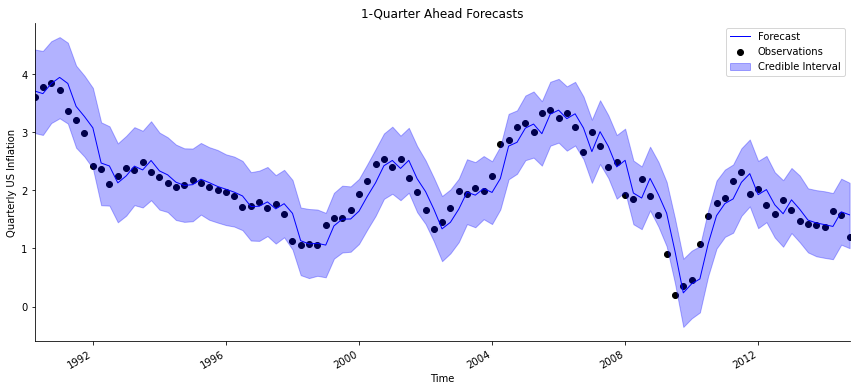

In [ ]:
forecast = median(samples)

# Plot the 1-quarter ahead forecast
h = 1
start = data[data.Date == forecast_start].index[0] + h
end = data[data.Date == forecast_end].index[0] + h + 1

fig, ax = plt.subplots(figsize=(12, 6))
plot_data_forecast(fig, ax, y = data[start:end].Inflation.values,
                   f = forecast[:,h-1],
                   samples = samples[:,:,h-1],
                   dates = pd.to_datetime(data[start:end].Date.values),
                   xlabel='Time', ylabel='Quarterly US Inflation', title='1-Quarter Ahead Forecasts');

We can see that the forecasts are quite good, and nearly all of the observations fall within the $95\%$ credible interval.

There's also a clear pattern - the forecasts look as if they're shifted forward from the data by 1 step. This is because the lag-1 predictor is very strong, with a coefficient mean of $0.91$. The model is primarily using the previous month's value as its forecast, with some small modifications. Having the previous value as our best forecast is common in many time series.

We can put a number on the quality of the forecast by using a loss function, the Mean Absolute Percent Error (MAPE). We see that on average, our forecasts of quarterly inflation have an error of under $15\%$.

In [ ]:
MAPE(data[start:end].Inflation.values, forecast[:,0]).round(1)

14.8

In [ ]:
assert(MAPE(data[start:end].Inflation.values, forecast[:,0]).round(0) <= 15)

Finally, we can use the returned model to forecast $1-$step ahead to Q1 2015, which is past the end of the dataset. We need the `X` value to forecast into the future. Luckily, in this model the predictor `X` is simply the previous value of Inflation from Q4 2014.

In [ ]:
x_future = data.Inflation.iloc[-1]
one_step_forecast_samples = mod.forecast_marginal(k=1,
                                                  X=x_future,
                                                  nsamps=1000000)

From here, we can find the mean and standard deviation of the forecast for next quarter's inflation:

In [ ]:
print('Mean: ' + str(np.mean(one_step_forecast_samples).round(2)))
print('Std Dev: ' + str(np.std(one_step_forecast_samples).round(2)))

Mean: 1.21
Std Dev: 0.29


We can also plot the full forecast distribution for Q1 2015:

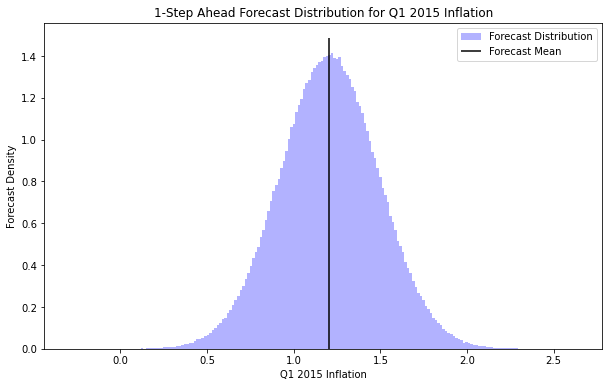

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(one_step_forecast_samples.reshape(-1),
        bins=200, alpha=0.3, color='b', density=True,
        label='Forecast Distribution');
ax.vlines(x=np.mean(one_step_forecast_samples),
          ymin=0, ymax=ax.get_ylim()[1],
          label='Forecast Mean');
ax.set_title('1-Step Ahead Forecast Distribution for Q1 2015 Inflation');
ax.set_ylabel('Forecast Density')
ax.set_xlabel('Q1 2015 Inflation')
ax.legend();

## Analysis for a DCMM

In [ ]:
#export
def analysis_dcmm(Y, X=None, k=1, forecast_start=0, forecast_end=0,
                  nsamps=500, rho=.6,
                  model_prior=None, prior_length=20, ntrend=1,
                  dates=None, holidays=[],
                  seasPeriods=[], seasHarmComponents=[], 
                  latent_factor=None, new_latent_factors=None,
                  mean_only=False,  
                  ret=['model', 'forecast'],
                   **kwargs):
    """
    This is a helpful function to run a standard analysis using a DCMM.
    """

    if latent_factor is not None:
        is_lf = True
        # Note: This assumes that the bernoulli & poisson components have the same number of latent factor components
        if isinstance(latent_factor, (list, tuple)):
            nlf = latent_factor[0].p
        else:
            nlf = latent_factor.p
    else:
        is_lf = False
        nlf = 0

    # Convert dates into row numbers
    if dates is not None:
        dates = pd.Series(dates)
        # dates = pd.to_datetime(dates, format='%y/%m/%d')
        if type(forecast_start) == type(dates.iloc[0]):
            forecast_start = np.where(dates == forecast_start)[0][0]
        if type(forecast_end) == type(dates.iloc[0]):
            forecast_end = np.where(dates == forecast_end)[0][0]

    # Add the holiday indicator variables to the regression matrix
    nhol = len(holidays)
    if nhol > 0:
        X = define_holiday_regressors(X, dates, holidays)

    # Initialize the DCMM
    if model_prior is None:
        mod = define_dcmm(Y, X, prior_length = prior_length, seasPeriods = seasPeriods, seasHarmComponents = seasHarmComponents,
                          ntrend=ntrend, nlf = nlf, rho = rho, nhol = nhol, **kwargs)
    else:
        mod = model_prior

    if ret.__contains__('new_latent_factors'):
        if not isinstance(new_latent_factors, Iterable):
            new_latent_factors = [new_latent_factors]

        tmp = []
        for sig in new_latent_factors:
            tmp.append(sig.copy())
        new_latent_factors = tmp
        
    T = len(Y) + 1 # np.min([len(Y), forecast_end]) + 1
    nu = 9
        
    if X is None:
        X = np.array([None]*(T+k)).reshape(-1,1)
    else:
        if len(X.shape) == 1:
            X = X.reshape(-1,1)

    # Initialize updating + forecasting
    horizons = np.arange(1,k+1)

    if mean_only:
        forecast = np.zeros([1, forecast_end - forecast_start + 1, k])
    else:
        forecast = np.zeros([nsamps, forecast_end - forecast_start + 1, k])

    # Run updating + forecasting
    for t in range(prior_length, T):
        # if t % 100 == 0:
        #     print(t)
        if ret.__contains__('forecast'):
            if t >= forecast_start and t <= forecast_end:
                if t == forecast_start:
                    print('beginning forecasting')

                # Get the forecast samples for all the items over the 1:k step ahead path
                if is_lf:
                    if isinstance(latent_factor, (list, tuple)):
                        pm_bern, ps_bern = latent_factor[0].get_lf_forecast(dates.iloc[t])
                        pm_pois, ps_pois = latent_factor[1].get_lf_forecast(dates.iloc[t])
                        pm = (pm_bern, pm_pois)
                        ps = (ps_bern, ps_pois)
                    else:
                        pm, ps = latent_factor.get_lf_forecast(dates.iloc[t])

                    pp = None  # Not including the path dependency of the latent factor

                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x, pm, ps: mod.forecast_marginal_lf_analytic(
                                k=k, X=(x, x), phi_mu=(pm, pm), phi_sigma=(ps, ps), nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :], pm, ps))).reshape(1, -1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_lf_copula(
                        k=k, X=(X[t + horizons - 1, :], X[t + horizons - 1, :]),
                        phi_mu=(pm, pm), phi_sigma=(ps, ps), phi_psi=(pp, pp), nsamps=nsamps, t_dist=True, nu=nu)
                else:
                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x: mod.forecast_marginal(
                                k=k, X=(x, x), nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :]))).reshape(1,-1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_copula(
                        k=k, X=(X[t + horizons - 1, :], X[t + horizons - 1, :]), nsamps=nsamps, t_dist=True, nu=nu)

        if ret.__contains__('new_latent_factors'):
            if t >= forecast_start and t <= forecast_end:
                for lf in new_latent_factors:
                    lf.generate_lf_forecast(date=dates.iloc[t], mod=mod, X=X[t + horizons - 1, :],
                                                k=k, nsamps=nsamps, horizons=horizons)

        # Update the DCMM
        if t < len(Y):
            if is_lf:
                if isinstance(latent_factor, (list, tuple)):
                    pm_bern, ps_bern = latent_factor[0].get_lf(dates.iloc[t])
                    pm_pois, ps_pois = latent_factor[1].get_lf(dates.iloc[t])
                    pm = (pm_bern, pm_pois)
                    ps = (ps_bern, ps_pois)
                else:
                    pm, ps = latent_factor.get_lf(dates.iloc[t])

                mod.update_lf_analytic(y=Y[t], X=(X[t], X[t]),
                                       phi_mu=(pm, pm), phi_sigma=(ps, ps))
            else:
                mod.update(y = Y[t], X=(X[t], X[t]))

            if ret.__contains__('new_latent_factors'):
                for lf in new_latent_factors:
                    lf.generate_lf(date=dates.iloc[t], mod=mod, X=X[t + horizons - 1, :],
                                       k=k, nsamps=nsamps, horizons=horizons)

    out = []
    for obj in ret:
        if obj == 'forecast': out.append(forecast)
        if obj == 'model': out.append(mod)
        if obj == 'new_latent_factors':
            #for lf in new_latent_factors:
            #    lf.append_lf()
            #    lf.append_lf_forecast()
            if len(new_latent_factors) == 1:
                out.append(new_latent_factors[0])
            else:
                out.append(new_latent_factors)

    if len(out) == 1:
        return out[0]
    else:
        return out

`analysis_dcmm` works identically to the standard `analysis`, but is specialized for a DCMM.

The observations must be integer counts, which are modeled as a combination of a Poisson and Bernoulli DGLM. Typically a DCMM is equally good as a Poisson DGLM for modeling series with consistently large integers, while being significantly better at modeling series with many zeros.

Note that by default, all simulated forecasts made with `analysis_dcmm` are *path* forecasts, meaning that they account for the dependence across forecast horizons.

## Analysis for a DBCM

In [ ]:
#export
def analysis_dbcm(Y_transaction, X_transaction, Y_cascade, X_cascade, excess,
                  k, forecast_start, forecast_end, nsamps = 500, rho = .6,
                  model_prior=None, prior_length=20, ntrend=1,
                  dates=None, holidays = [],
                  latent_factor = None, new_latent_factors = None,
                  seasPeriods = [], seasHarmComponents = [],
                  mean_only=False,        
                  ret=['model', 'forecast'],
                   **kwargs):
    """
    This is a helpful function to run a standard analysis using a DBCM.
    """

    if latent_factor is not None:
        is_lf = True
        # Note: This assumes that the bernoulli & poisson components have the same number of latent factor components
        if isinstance(latent_factor, (list, tuple)):
            nlf = latent_factor[0].p
        else:
            nlf = latent_factor.p
    else:
        is_lf = False
        nlf = 0

    # Convert dates into row numbers
    if dates is not None:
        dates = pd.Series(dates)
        # dates = pd.to_datetime(dates, format='%y/%m/%d')
        if type(forecast_start) == type(dates.iloc[0]):
            forecast_start = np.where(dates == forecast_start)[0][0]
        if type(forecast_end) == type(dates.iloc[0]):
            forecast_end = np.where(dates == forecast_end)[0][0]

    # Add the holiday indicator variables to the regression matrix
    nhol = len(holidays)
    if nhol > 0:
        X_transaction = define_holiday_regressors(X_transaction, dates, holidays)


    if model_prior is None:
        mod = define_dbcm(Y_transaction, X_transaction, Y_cascade, X_cascade,
                          excess_values = excess, prior_length = prior_length,
                          seasPeriods = seasPeriods, seasHarmComponents=seasHarmComponents,
                          nlf = nlf, rho = rho, nhol=nhol, **kwargs)
    else:
        mod = model_prior

    if ret.__contains__('new_latent_factors'):
        if not isinstance(new_latent_factors, Iterable):
            new_latent_factors = [new_latent_factors]

        tmp = []
        for sig in new_latent_factors:
            tmp.append(sig.copy())
        new_latent_factors = tmp

    # Initialize updating + forecasting
    horizons = np.arange(1,k+1)

    if mean_only:
        forecast = np.zeros([1, forecast_end - forecast_start + 1, k])
    else:
        forecast = np.zeros([nsamps, forecast_end - forecast_start + 1, k])

    T = len(Y_transaction) + 1 #np.min([len(Y_transaction)- k, forecast_end]) + 1
    nu = 9

    # Run updating + forecasting
    for t in range(prior_length, T):
        # if t % 100 == 0:
        #     print(t)
            # print(mod.dcmm.pois_mod.param1)
            # print(mod.dcmm.pois_mod.param2)
        if ret.__contains__('forecast'):
            if t >= forecast_start and t <= forecast_end:
                if t == forecast_start:
                    print('beginning forecasting')

                # Get the forecast samples for all the items over the 1:k step ahead path
                if is_lf:
                    if isinstance(latent_factor, (list, tuple)):
                        pm_bern, ps_bern = latent_factor[0].get_lf_forecast(dates.iloc[t])
                        pm_pois, ps_pois = latent_factor[1].get_lf_forecast(dates.iloc[t])
                        pm = (pm_bern, pm_pois)
                        ps = (ps_bern, ps_pois)
                        pp = None  # Not including path dependency in latent factor
                    else:
                        if latent_factor.forecast_path:
                            pm, ps, pp = latent_factor.get_lf_forecast(dates.iloc[t])
                        else:
                            pm, ps = latent_factor.get_lf_forecast(dates.iloc[t])
                            pp = None

                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x_trans, x_cascade, pm, ps: mod.forecast_marginal_lf_analytic(
                                k=k, X_transaction=x_trans, X_cascade=x_cascade,
                                phi_mu=pm, phi_sigma=ps, nsamps=nsamps, mean_only=mean_only),
                            horizons, X_transaction[t + horizons - 1, :], X_cascade[t + horizons - 1, :], pm, ps))).reshape(1, -1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_lf_copula(
                            k=k, X_transaction=X_transaction[t + horizons - 1, :], X_cascade=X_cascade[t + horizons - 1, :],
                            phi_mu=pm, phi_sigma=ps, phi_psi=pp, nsamps=nsamps, t_dist=True, nu=nu)
                else:
                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x_trans, x_cascade: mod.forecast_marginal(
                                k=k, X_transaction=x_trans, X_cascade=x_cascade, nsamps=nsamps, mean_only=mean_only),
                            horizons, X_transaction[t + horizons - 1, :], X_cascade[t + horizons - 1, :]))).reshape(1,-1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_copula(
                            k=k, X_transaction=X_transaction[t + horizons - 1, :], X_cascade=X_cascade[t + horizons - 1, :],
                            nsamps=nsamps, t_dist=True, nu=nu)

        if ret.__contains__('new_latent_factors'):
            if t >= forecast_start and t <= forecast_end:
                for lf in new_latent_factors:
                    lf.generate_lf_forecast(date=dates.iloc[t], mod=mod, X_transaction=X_transaction[t + horizons - 1, :],
                                                X_cascade = X_cascade[t + horizons - 1, :],
                                                k=k, nsamps=nsamps, horizons=horizons)
        # Update the DBCM
        if t < len(Y_transaction):
            if is_lf:
                if isinstance(latent_factor, (list, tuple)):
                    pm_bern, ps_bern = latent_factor[0].get_lf(dates.iloc[t])
                    pm_pois, ps_pois = latent_factor[1].get_lf(dates.iloc[t])
                    pm = (pm_bern, pm_pois)
                    ps = (ps_bern, ps_pois)
                else:
                    pm, ps = latent_factor.get_lf(dates.iloc[t])

                mod.update_lf_analytic(y_transaction=Y_transaction[t], X_transaction=X_transaction[t, :],
                                       y_cascade=Y_cascade[t,:], X_cascade=X_cascade[t, :],
                                       phi_mu=pm, phi_sigma=ps, excess=excess[t])
            else:
                mod.update(y_transaction=Y_transaction[t], X_transaction=X_transaction[t, :],
                           y_cascade=Y_cascade[t,:], X_cascade=X_cascade[t, :], excess=excess[t])

            if ret.__contains__('new_latent_factors'):
                for lf in new_latent_factors:
                    lf.generate_lf(date=dates.iloc[t], mod=mod, X_transaction=X_transaction[t + horizons - 1, :],
                                       X_cascade = X_cascade[t + horizons - 1, :],
                                       k=k, nsamps=nsamps, horizons=horizons)

    out = []
    for obj in ret:
        if obj == 'forecast': out.append(forecast)
        if obj == 'model': out.append(mod)
        if obj == 'new_latent_factors':
            #for lf in new_latent_factors:
            #    lf.append_lf()
            #    lf.append_lf_forecast()
            if len(new_latent_factors) == 1:
                out.append(new_latent_factors[0])
            else:
                out.append(new_latent_factors)

    if len(out) == 1:
        return out[0]
    else:
        return out

`analysis_dbcm` works identically to the standard `analysis`, but is specialized for a DBCM.

Separate data must be specified for the DCMM on transactions, `y_transaction` and `X_transaction`, the binomial cascade,`y_cascade`, `X_cascade`, and any excess counts, `excess`.

Note that by default, all simulated forecasts made with `analysis_dbcm` are *path* forecasts, meaning that they account for the dependence across forecast horizons.

## Analysis for a DLMM

In [ ]:
#export
def analysis_dlmm(Y, X, k=1, forecast_start=0, forecast_end=0,
                  nsamps=500, rho=.6,
                  model_prior=None, prior_length=20, ntrend=1,
                  dates=None, holidays=[],
                  seasPeriods=[], seasHarmComponents=[], 
                  latent_factor=None, new_latent_factors=None,
                  mean_only=False,  
                  ret=['model', 'forecast'],
                   **kwargs):
    """
    This is a helpful function to run a standard analysis using a DLMM.
    """

    if latent_factor is not None:
        is_lf = True
        # Note: This assumes that the bernoulli & poisson components have the same number of latent factor components
        if isinstance(latent_factor, (list, tuple)):
            nlf = latent_factor[0].p
        else:
            nlf = latent_factor.p
    else:
        is_lf = False
        nlf = 0

    # Convert dates into row numbers
    if dates is not None:
        dates = pd.Series(dates)
        # dates = pd.to_datetime(dates, format='%y/%m/%d')
        if type(forecast_start) == type(dates.iloc[0]):
            forecast_start = np.where(dates == forecast_start)[0][0]
        if type(forecast_end) == type(dates.iloc[0]):
            forecast_end = np.where(dates == forecast_end)[0][0]

    # Add the holiday indicator variables to the regression matrix
    nhol = len(holidays)
    if nhol > 0:
        X = define_holiday_regressors(X, dates, holidays)

    # Initialize the DCMM
    if model_prior is None:
        mod = define_dlmm(Y, X, prior_length = prior_length, seasPeriods = seasPeriods, seasHarmComponents = seasHarmComponents,
                          ntrend=ntrend, nlf = nlf, rho = rho, nhol = nhol, **kwargs)
    else:
        mod = model_prior

    if ret.__contains__('new_latent_factors'):
        if not isinstance(new_latent_factors, Iterable):
            new_latent_factors = [new_latent_factors]

        tmp = []
        for sig in new_latent_factors:
            tmp.append(sig.copy())
        new_latent_factors = tmp
        
    if ret.__contains__('model_coef'): ## Return normal dlm params 
        m = np.zeros([T, mod.dlm_mod.a.shape[0]])
        C = np.zeros([T, mod.dlm_mod.a.shape[0], mod.dlm_mod.a.shape[0]])
        a = np.zeros([T, mod.dlm_mod.a.shape[0]])
        R = np.zeros([T, mod.dlm_mod.a.shape[0], mod.dlm_mod.a.shape[0]])
        n = np.zeros(T)
        s = np.zeros(T)

    # Initialize updating + forecasting
    horizons = np.arange(1,k+1)

    if mean_only:
        forecast = np.zeros([1, forecast_end - forecast_start + 1, k])
    else:
        forecast = np.zeros([nsamps, forecast_end - forecast_start + 1, k])

    T = len(Y) + 1
    nu = 9
    
    # Run updating + forecasting
    for t in range(prior_length, T):
        # if t % 100 == 0:
        #     print(t)
        if ret.__contains__('forecast'):
            if t >= forecast_start and t <= forecast_end:
                if t == forecast_start:
                    print('beginning forecasting')

                # Get the forecast samples for all the items over the 1:k step ahead path
                if is_lf:
                    if isinstance(latent_factor, (list, tuple)):
                        pm_bern, ps_bern = latent_factor[0].get_lf_forecast(dates.iloc[t])
                        pm_dlm, ps_dlm = latent_factor[1].get_lf_forecast(dates.iloc[t])
                        pm = (pm_bern, pm_dlm)
                        ps = (ps_bern, ps_dlm)
                    else:
                        pm, ps = latent_factor.get_lf_forecast(dates.iloc[t])

                    pp = None  # Not including the path dependency of the latent factor

                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x, pm, ps: mod.forecast_marginal_lf_analytic(
                                k=k, X=(x, x), phi_mu=(pm, pm), phi_sigma=(ps, ps), nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :], pm, ps))).reshape(1, -1)
                    else:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x, pm, ps: mod.forecast_marginal_lf_analytic(
                                k=k, X=(x, x), phi_mu=(pm, pm), phi_sigma=(ps, ps), nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :], pm, ps))).squeeze().T.reshape(-1, k)
                        
                else:
                    if mean_only:
                        forecast[:, t - forecast_start, :] = np.array(list(map(
                            lambda k, x: mod.forecast_marginal(
                                k=k, X=(x, x), nsamps=nsamps, mean_only=mean_only),
                            horizons, X[t + horizons - 1, :]))).reshape(1,-1)
                    else:
                        forecast[:, t - forecast_start, :] = mod.forecast_path_copula(
                        k=k, X=(X[t + horizons - 1, :], X[t + horizons - 1, :]), nsamps=nsamps, t_dist=True, nu=nu)

        if ret.__contains__('new_latent_factors'):
            if t >= forecast_start and t <= forecast_end:
                for lf in new_latent_factors:
                    lf.generate_lf_forecast(date=dates.iloc[t], mod=mod, X=X[t + horizons - 1, :],
                                                k=k, nsamps=nsamps, horizons=horizons)

        # Update the DLMM
        if t < len(Y):
            if is_lf:
                if isinstance(latent_factor, (list, tuple)):
                    pm_bern, ps_bern = latent_factor[0].get_lf(dates.iloc[t])
                    pm_dlm, ps_dlm = latent_factor[1].get_lf(dates.iloc[t])
                    pm = (pm_bern, pm_dlm)
                    ps = (ps_bern, ps_dlm)
                else:
                    pm, ps = latent_factor.get_lf(dates.iloc[t])

                mod.update_lf_analytic(y=Y[t], X=(X[t], X[t]),
                                       phi_mu=(pm, pm), phi_sigma=(ps, ps))
            else:
                mod.update(y = Y[t], X=(X[t], X[t]))

            if ret.__contains__('new_latent_factors'):
                for lf in new_latent_factors:
                    lf.generate_lf(date=dates.iloc[t], mod=mod, X=X[t + horizons - 1, :],
                                       k=k, nsamps=nsamps, horizons=horizons)
                    
        # Store the dlm coefficients            
        if ret.__contains__('model_coef'):
            m[t,:] = mod.dlm.m.reshape(-1)
            C[t,:,:] = mod.dlm.C
            a[t,:] = mod.dlm.a.reshape(-1)
            R[t,:,:] = mod.dlm.R
            n[t] = mod.dlm.n / mod.dlm.delVar
            s[t] = mod.dlm.s

    out = []
    for obj in ret:
        if obj == 'forecast': out.append(forecast)
        if obj == 'model': out.append(mod)
        if obj == 'model_coef':
            mod_coef = {'m':m, 'C':C, 'a':a, 'R':R, 'n':n, 's':s}
            out.append(mod_coef)
        if obj == 'new_latent_factors':
            #for lf in new_latent_factors:
            #    lf.append_lf()
            #    lf.append_lf_forecast()
            if len(new_latent_factors) == 1:
                out.append(new_latent_factors[0])
            else:
                out.append(new_latent_factors)

    if len(out) == 1:
        return out[0]
    else:
        return out

`analysis_dlmm` works identically to the standard `analysis`, but is specialized for a DLMM.  `analysis_dlmm` returns the model coefficients for the Normal DLM portion of the model only.

The observations are continuous and are modeled as a combination of a Bernoulli DGLM and a Normal DLM. 

Note that by default, all simulated forecasts made with `analysis_dlmm` are *path* forecasts, meaning that they account for the dependence across forecast horizons. The exception is for latent factor DLMMs, which default to marginal forecasting.

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_dglm.ipynb.
Converted 01_update.ipynb.
Converted 02_forecast.ipynb.
Converted 03_define_models.ipynb.
Converted 04_seasonal.ipynb.
Converted 05_analysis.ipynb.
Converted 06_conjugates.ipynb.
Converted 07_point_forecast.ipynb.
Converted 08_loss_functions.ipynb.
Converted 09_plot.ipynb.
Converted 10_shared.ipynb.
Converted 11_dcmm.ipynb.
Converted 12_dbcm.ipynb.
Converted 13_latent_factor.ipynb.
Converted 14_latent_factor_fxns.ipynb.
Converted 15_dlmm.ipynb.
Converted index.ipynb.
